Ref : https://github.com/aliasvishnu/EEGNet/blob/master/EEGNet-PyTorch.ipynb

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import accuracy_score

In [2]:
#Load data function

def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label

<h3>EEGNet and DeepConvNet function</h3>

In [3]:
class EEGNet(nn.Module):
    def __init__(self,activation_name):
        super(EEGNet, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 51), padding = (0,25),bias=False)
        self.batchnorm1 = nn.BatchNorm2d(16, eps=1e-5)
        
        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, (2, 1),groups=16,bias=False)
        self.batchnorm2 = nn.BatchNorm2d(32, eps=1e-5)
        if activation_name=='relu':
            self.act1=nn.ReLU()
        elif activation_name=='leakyrelu':
            self.act1=nn.LeakyReLU()
        elif activation_name=='elu':
            self.act1=nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 4))
        self.drop1 = nn.Dropout(p=0.5)
        
        # Layer 3
        self.conv3 = nn.Conv2d(32, 32, (1, 15),padding = (0,7),bias=False)
        self.batchnorm3 = nn.BatchNorm2d(32, eps=1e-5)
        if activation_name=='relu':
            self.act2=nn.ReLU()
        elif activation_name=='leakyrelu':
            self.act2=nn.LeakyReLU()
        elif activation_name=='elu':
            self.act2=nn.ELU()
        self.pooling3 = nn.AvgPool2d((1, 8))
        self.drop2 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(736, 2,bias=True)
        

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        # Layer 2
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.act1(x)
        x = self.pooling2(x)
        x = self.drop1(x)
        
        # Layer 3
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.act2(x)
        x = self.pooling3(x)
        x = self.drop2(x)
        
        # FC Layer
        x = x.view(-1, 736)
        x = F.sigmoid(self.fc1(x))
        
        return x


class DeepConvNet(nn.Module):
    def __init__(self,activation_name):
        super(DeepConvNet, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 25, (1, 5))
        self.conv2 = nn.Conv2d(25, 25, (2, 1))
        self.batchnorm1 = nn.BatchNorm2d(25, eps=1e-5)
        if activation_name=='relu':
            self.act1=nn.ReLU()
        elif activation_name=='leakyrelu':
            self.act1=nn.LeakyReLU()
        elif activation_name=='elu':
            self.act1=nn.ELU()
        self.pooling1 = nn.MaxPool2d((1, 2))
        self.drop1 = nn.Dropout(p=0.25)
        
        
        # Layer 2
        self.conv3 = nn.Conv2d(25, 50, (1, 5))
        self.batchnorm2 = nn.BatchNorm2d(50, eps=1e-5)
        if activation_name=='relu':
            self.act2=nn.ReLU()
        elif activation_name=='leakyrelu':
            self.act2=nn.LeakyReLU()
        elif activation_name=='elu':
            self.act2=nn.ELU()
        self.pooling2 = nn.MaxPool2d((1, 2))
        self.drop2 = nn.Dropout(p=0.25)
        
        # Layer 3
        self.conv4 = nn.Conv2d(50, 100, (1, 5))
        self.batchnorm3 = nn.BatchNorm2d(100, eps=1e-5)
        if activation_name=='relu':
            self.act3=nn.ReLU()
        elif activation_name=='leakyrelu':
            self.act3=nn.LeakyReLU()
        elif activation_name=='elu':
            self.act3=nn.ELU()
        self.pooling3 = nn.MaxPool2d((1, 2))
        self.drop3 = nn.Dropout(p=0.25)
        
        # Layer 4
        self.conv5 = nn.Conv2d(100, 200, (1, 5))
        self.batchnorm4 = nn.BatchNorm2d(200, eps=1e-5)
        if activation_name=='relu':
            self.act4=nn.ReLU()
        elif activation_name=='leakyrelu':
            self.act4=nn.LeakyReLU()
        elif activation_name=='elu':
            self.act4=nn.ELU()
        self.pooling4 = nn.MaxPool2d((1, 2))
        self.drop4 = nn.Dropout(p=0.25)
        
        self.fc1 = nn.Linear(8600, 2,bias=True)
        

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.batchnorm1(x)
        x = self.act1(x)
        x = self.pooling1(x)
        x = self.drop1(x)
        
        # Layer 2
        x = self.conv3(x)
        x = self.batchnorm2(x)
        x = self.act2(x)
        x = self.pooling2(x)
        x = self.drop2(x)
        
        # Layer 3
        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = self.act3(x)
        x = self.pooling3(x)
        x = self.drop3(x)

        # Layer 4
        x = self.conv5(x)
        x = self.batchnorm4(x)
        x = self.act4(x)
        x = self.pooling4(x)
        x = self.drop4(x)
        
        # FC Layer
        x = x.view(-1, 8600)
        x = F.softmax(self.fc1(x))
        return x

<h3>Evaluate function</h3>

In [4]:
def evaluate(model, X, Y):
    results = []
    batch_size = 72
    
    predicted = []
    
    for i in range(15):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = torch.from_numpy(X[s:e])
        inputs = Variable(inputs.to(device='cuda:0', dtype=torch.float))
        pred = model(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
    inputs = Variable(torch.from_numpy(X).to(device='cuda:0', dtype=torch.float))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy()
    acc=accuracy_score(Y, np.argmax(predicted,axis=-1))
            
    return acc

<h3>Create data、model</h3>

In [5]:
train_data, train_label, test_data, test_label=read_bci_data()

# net = EEGNet("elu").cuda(0)
# net = EEGNet("relu").cuda(0)
net = EEGNet("leakyrelu").cuda(0)
# net = DeepConvNet("elu").cuda(0)
# net = DeepConvNet("relu").cuda(0)
# net = DeepConvNet("leakyrelu").cuda(0)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=1e-3)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5) #Reduce learning rate
net

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


EEGNet(
  (conv1): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (pooling2): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (drop1): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
  (batchnorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (pooling3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=736, out_features=2, bias=True)
)

<h3>Model structure</h3>

In [6]:
from torchsummary import summary

summary(net, (1, 2, 750))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 2, 750]             816
       BatchNorm2d-2           [-1, 16, 2, 750]              32
            Conv2d-3           [-1, 32, 1, 750]              64
       BatchNorm2d-4           [-1, 32, 1, 750]              64
         LeakyReLU-5           [-1, 32, 1, 750]               0
         AvgPool2d-6           [-1, 32, 1, 187]               0
           Dropout-7           [-1, 32, 1, 187]               0
            Conv2d-8           [-1, 32, 1, 187]          15,360
       BatchNorm2d-9           [-1, 32, 1, 187]              64
        LeakyReLU-10           [-1, 32, 1, 187]               0
        AvgPool2d-11            [-1, 32, 1, 23]               0
          Dropout-12            [-1, 32, 1, 23]               0
           Linear-13                    [-1, 2]           1,474
Total params: 17,874
Trainable params: 

D:\anaconda3\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<h3>Training</h3>

In [7]:
batch_size = 72
train_acc_list=[]
test_acc_list=[]
for epoch in range(300):  # loop over the dataset multiple times
    print ("\nEpoch ", epoch)
    
    running_loss = 0.0
    acc=0.0
    for i in range(15):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = torch.from_numpy(train_data[s:e])
        labels = torch.FloatTensor(np.array(train_label[s:e]))
        
        # wrap them in Variable
        inputs, labels = Variable(inputs.to(device='cuda:0', dtype=torch.float)), Variable(labels.to(device='cuda:0', dtype=torch.float))
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels.long())
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        outputs[outputs>0.5]=1
        outputs[outputs<=0.5]=0
        outputs_=outputs.data.cpu().numpy()
        labels_=labels.data.cpu().numpy()
        acc+=accuracy_score(labels_, np.argmax(outputs_,axis=-1))/15
    train_acc_list.append(acc)
    scheduler.step()
    
    # Validation accuracy
    test_acc = evaluate(net, test_data, test_label)
    test_acc_list.append(test_acc)
    print ("Training Loss : ", np.round(running_loss,4),", Training Accuracy : ", 
           np.round(acc,4) , ", Test Accuracy : ", np.round(test_acc,4))
    
    #Stop training
    if test_acc>0.87:
        print(test_acc)
        break


Epoch  0
Training Loss :  10.2937 , Training Accuracy :  0.5306 , Test Accuracy :  0.6213

Epoch  1
Training Loss :  9.6263 , Training Accuracy :  0.662 , Test Accuracy :  0.6935

Epoch  2
Training Loss :  8.9499 , Training Accuracy :  0.713 , Test Accuracy :  0.7102

Epoch  3
Training Loss :  8.6025 , Training Accuracy :  0.738 , Test Accuracy :  0.7093

Epoch  4
Training Loss :  8.4186 , Training Accuracy :  0.7269 , Test Accuracy :  0.7

Epoch  5
Training Loss :  8.3399 , Training Accuracy :  0.7417 , Test Accuracy :  0.7056

Epoch  6
Training Loss :  8.1701 , Training Accuracy :  0.7556 , Test Accuracy :  0.6991

Epoch  7
Training Loss :  8.1506 , Training Accuracy :  0.7639 , Test Accuracy :  0.7074

Epoch  8
Training Loss :  8.1176 , Training Accuracy :  0.7713 , Test Accuracy :  0.7065

Epoch  9
Training Loss :  8.0609 , Training Accuracy :  0.7676 , Test Accuracy :  0.7176

Epoch  10
Training Loss :  8.0464 , Training Accuracy :  0.763 , Test Accuracy :  0.7046

Epoch  11
Trai

Training Loss :  6.2853 , Training Accuracy :  0.8935 , Test Accuracy :  0.8074

Epoch  93
Training Loss :  6.3799 , Training Accuracy :  0.8815 , Test Accuracy :  0.813

Epoch  94
Training Loss :  6.3586 , Training Accuracy :  0.8898 , Test Accuracy :  0.8093

Epoch  95
Training Loss :  6.2877 , Training Accuracy :  0.8981 , Test Accuracy :  0.8046

Epoch  96
Training Loss :  6.3695 , Training Accuracy :  0.8907 , Test Accuracy :  0.8111

Epoch  97
Training Loss :  6.2796 , Training Accuracy :  0.8963 , Test Accuracy :  0.8241

Epoch  98
Training Loss :  6.4395 , Training Accuracy :  0.8769 , Test Accuracy :  0.8139

Epoch  99
Training Loss :  6.3129 , Training Accuracy :  0.8935 , Test Accuracy :  0.8176

Epoch  100
Training Loss :  6.3376 , Training Accuracy :  0.8917 , Test Accuracy :  0.8213

Epoch  101
Training Loss :  6.3411 , Training Accuracy :  0.8889 , Test Accuracy :  0.8241

Epoch  102
Training Loss :  6.2608 , Training Accuracy :  0.8991 , Test Accuracy :  0.8176

Epoch  

Training Loss :  6.1639 , Training Accuracy :  0.9074 , Test Accuracy :  0.837

Epoch  183
Training Loss :  6.0698 , Training Accuracy :  0.913 , Test Accuracy :  0.8148

Epoch  184
Training Loss :  6.1304 , Training Accuracy :  0.9102 , Test Accuracy :  0.8259

Epoch  185
Training Loss :  6.0345 , Training Accuracy :  0.9185 , Test Accuracy :  0.8176

Epoch  186
Training Loss :  6.2381 , Training Accuracy :  0.8954 , Test Accuracy :  0.8287

Epoch  187
Training Loss :  6.1866 , Training Accuracy :  0.9037 , Test Accuracy :  0.8269

Epoch  188
Training Loss :  6.117 , Training Accuracy :  0.9046 , Test Accuracy :  0.8222

Epoch  189
Training Loss :  6.136 , Training Accuracy :  0.9065 , Test Accuracy :  0.8333

Epoch  190
Training Loss :  6.0053 , Training Accuracy :  0.9194 , Test Accuracy :  0.8306

Epoch  191
Training Loss :  6.045 , Training Accuracy :  0.9176 , Test Accuracy :  0.825

Epoch  192
Training Loss :  6.2622 , Training Accuracy :  0.8926 , Test Accuracy :  0.8213

Epoch

Training Loss :  5.9942 , Training Accuracy :  0.9139 , Test Accuracy :  0.8102

Epoch  273
Training Loss :  5.9867 , Training Accuracy :  0.9167 , Test Accuracy :  0.8167

Epoch  274
Training Loss :  6.0605 , Training Accuracy :  0.9065 , Test Accuracy :  0.8287

Epoch  275
Training Loss :  6.2605 , Training Accuracy :  0.8954 , Test Accuracy :  0.8324

Epoch  276
Training Loss :  6.1231 , Training Accuracy :  0.9065 , Test Accuracy :  0.8111

Epoch  277
Training Loss :  5.9434 , Training Accuracy :  0.9213 , Test Accuracy :  0.8241

Epoch  278
Training Loss :  6.0252 , Training Accuracy :  0.9176 , Test Accuracy :  0.8269

Epoch  279
Training Loss :  6.0603 , Training Accuracy :  0.912 , Test Accuracy :  0.8204

Epoch  280
Training Loss :  6.055 , Training Accuracy :  0.912 , Test Accuracy :  0.8102

Epoch  281
Training Loss :  6.0277 , Training Accuracy :  0.913 , Test Accuracy :  0.8139

Epoch  282
Training Loss :  6.2616 , Training Accuracy :  0.8907 , Test Accuracy :  0.8167

Epo

In [8]:
#Max accuracy on test set

np.array(test_acc_list).max()

0.8481481481481481

<h3>Accuracy curve</h3>

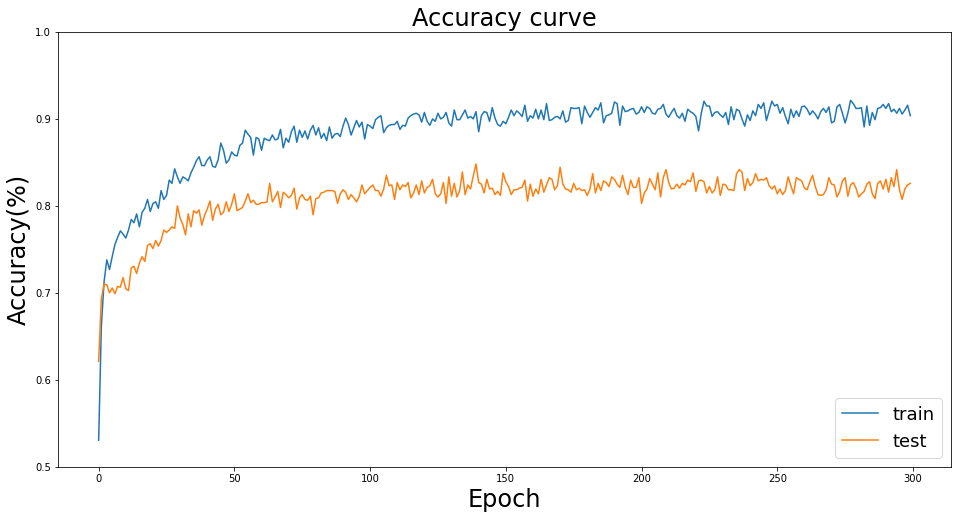

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
axes = plt.gca()
axes.set_ylim([0.5,1])
plt.title("Accuracy curve",fontsize=24) 
plt.ylabel("Accuracy(%)",fontsize=24) 
plt.xlabel("Epoch",fontsize=24) 
plt.plot(range(300),train_acc_list)
plt.plot(range(300),test_acc_list)
plt.legend(["train","test"], loc='lower right',fontsize=18)
plt.show()